# Practical: MD and MC

In this practical, we will learn how to run MD simulations using ASE. We will also learn how to write a Monte Carlo code running a Ising model simulation.

## Molecular Dynamics: Cu Melting
In this example, we will learn how to use molecular dynamics to simulate the melting of a copper crystal. We will use the EMT potential to describe the interactions between the atoms.

It's better to install the ASAP3 package to run the EMT potential, which is faster than the implementation in ASE. You can run the code below to install this package.

In [ ]:
!pip install --upgrade asap3

The code has following steps:
1. Create a copper crystal.
2. Define the EMT potential.
3. Run the molecular dynamics simulation using `VelocityVerlet` algorithm. (NVE ensemble)
4. `MDLogger` to log the temperature and energy of the system.
5. Save the trajectory of the simulation.

In [ ]:
import os
from asap3 import EMT

from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.nvtberendsen import NVTBerendsen
from ase.md import MDLogger
from ase import units
from time import perf_counter
import numpy as np


# Set up a fcc-Cu crystal
atoms = bulk("Cu", "fcc", cubic=True, a=3.615)
atoms.pbc = True
atoms *= 3 # 3x3x3 supercell
print("atoms = ",atoms)

# Set calculator (EMT in this case)
calculator = EMT()
atoms.calc = calculator

# input parameters
time_step    = 1.0      # MD step size in fsec
temperature  = 2000     # Temperature in Kelvin
num_md_steps = 100000   # Total number of MD steps
num_interval = 1000     # Print out interval for .log and .traj

# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# Set output filenames
output_filename = "./Cu_fcc_3x3x3"
log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)

# Remove old files if they exist
if os.path.exists(log_filename): os.remove(log_filename)
if os.path.exists(traj_filename): os.remove(traj_filename)

# Define the MD dynamics class object
# dyn = VelocityVerlet(atoms,
#                      time_step * units.fs,
#                      trajectory = traj_filename,
#                      loginterval=num_interval
#                     )

dyn = NVTBerendsen(atoms,
                   time_step * units.fs,
                   temperature_K=temperature,
                   taut=100.0 * units.fs,
                   trajectory = traj_filename,
                   loginterval=num_interval
                  )
# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    time_md = time_step*imd
    etot  = atoms.get_total_energy()
    ekin  = atoms.get_kinetic_energy()
    epot  = atoms.get_potential_energy()
    temp_K = atoms.get_temperature()
    print(f"   {imd: >3}     {etot:.9f}     {ekin:.9f}    {epot:.9f}   {temp_K:.2f}")

dyn.attach(print_dyn, interval=num_interval)

# Set MD logger
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=False,peratom=False, mode="w"), interval=num_interval)

# Now run MD simulation
print(f"\n    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)")
dyn.run(num_md_steps)

print("\nNormal termination of the MD run!")


You can load the log file using pandas and see the evolution of the temperature and energy of the system.

In [17]:
import pandas as pd

df = pd.read_csv(log_filename, delim_whitespace=True)
df

/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_33312/510401485.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(log_filename, delim_whitespace=True)


,Time[ps],Etot[eV],Epot[eV],Ekin[eV],T[K]
0,0.0,129.286,0.026,129.260,2000.0
1,1.0,257.191,128.581,128.610,1989.9
2,2.0,258.740,127.844,130.897,2025.3
3,3.0,258.273,127.815,130.457,2018.5
4,4.0,258.298,125.821,132.477,2049.8
...,...,...,...,...,...
96,96.0,260.926,131.124,129.802,2008.4
97,97.0,259.524,130.503,129.021,1996.3
98,98.0,258.748,132.956,125.792,1946.3
99,99.0,259.246,130.850,128.395,1986.6


You can plot the results using matplotlib.

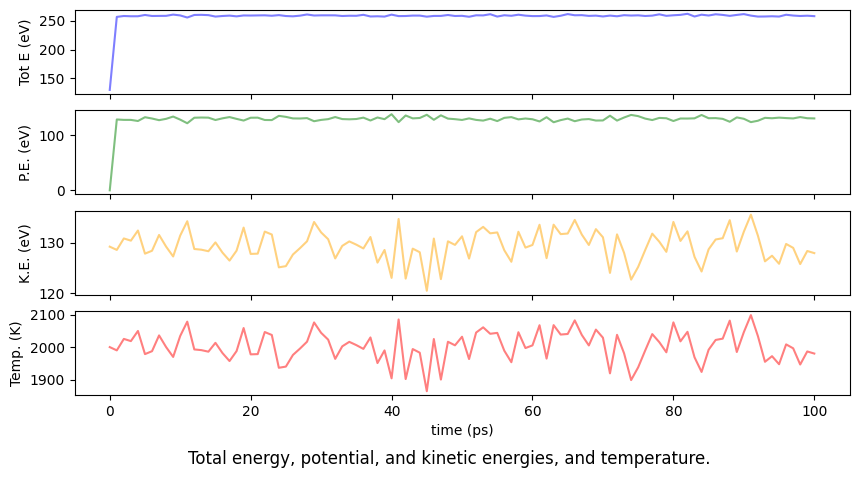

In [18]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

#color = 'tab:grey'
ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])
ax1.set_ylabel('Tot E (eV)')
ax1.plot(df["Time[ps]"], df["Etot[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])
ax2.set_ylabel('P.E. (eV)')
ax2.plot(df["Time[ps]"], df["Epot[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])
ax3.set_ylabel('K.E. (eV)')
ax3.plot(df["Time[ps]"], df["Ekin[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')
ax4.set_ylabel('Temp. (K)')
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)

fig.suptitle("Total energy, potential, and kinetic energies, and temperature.", y=0)

plt.show()


### Visualizing the simulation
We can use ase-gui to visualize our results.

In [19]:
!ase gui Cu_fcc_3x3x3.traj

2025-03-12 02:59:23.425 Python[35146:490314] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-12 02:59:23.425 Python[35146:490314] +[IMKInputSession subclass]: chose IMKInputSession_Modern


## Molecular Dynamics: Thermal Expansion of Cu
In this example, we will learn how to use molecular dynamics to simulate the thermal expansion of a copper crystal. We will use the EMT potential to describe the interactions between the atoms.

In [20]:
import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter


# ASAP3-EMT calculator
from asap3 import EMT
calculator = EMT()


# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 3
atoms_in.pbc = True
print("atoms_in = ",atoms_in)

# input parameters
time_step    = 1.0    # fsec
#temperature = 300    # Kelvin
num_md_steps = 20000
num_interval = 10

sigma   = 1.0     # External pressure in bar
ttime   = 20.0    # Time constant in fs
pfactor = 2e6     # Barostat parameter in GPa
temperature_list = [200,300,400,500,600,700,800,900,1000]

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


# run MD
for i,temperature in enumerate(temperature_list):
    print("i,temperature = ",i,temperature)

    print(f"sigma = {sigma:.1e} bar")
    print(f"ttime = {ttime:.3f} fs")
    print(f"pfactor = {pfactor:.3f} GPa*fs^2")

    temperature_str = str(int(temperature)).zfill(4)
    output_filename = f"./fcc-Cu_3x3x3_NPT_EMT_{temperature_str}K"
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"
    print("log_filename = ",log_filename)
    print("traj_filename = ",traj_filename)

    atoms = atoms_in.copy()
    atoms.calc = calculator

    # Set the momenta corresponding to T=300K
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)

    dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = sigma*units.bar,
          ttime = ttime*units.fs,
          pfactor = pfactor*units.GPa*(units.fs**2),
          logfile = log_filename,
          trajectory = traj_filename,
          loginterval=num_interval
          )

    print_interval = 1000
    dyn.attach(print_dyn, interval=print_interval)
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
    dyn.run(num_md_steps)

atoms_in =  Atoms(symbols='Cu108', pbc=True, cell=[10.83, 10.83, 10.83])
i,temperature =  0 200
sigma = 1.0e+00 bar
ttime = 20.000 fs
pfactor = 2000000.000 GPa*fs^2
log_filename =  ./fcc-Cu_3x3x3_NPT_EMT_0200K.log
traj_filename =  ./fcc-Cu_3x3x3_NPT_EMT_0200K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
  1000   3.318    148.92    1.00  1.15  0.94  0.91  0.11  0.27  -0.07    0.397
  2000   4.368    182.30    1.04  1.09  0.86  1.18  -0.08  0.42  0.01    0.764
  3000   5.197    189.36    0.54  0.38  0.45  0.80  -0.15  0.37  -0.12    1.124
  4000   6.252    215.40    -0.40  -0.70  -0.61  0.12  0.26  0.46  0.17    1.480
  5000   6.346    226.85    -0.83  -0.77  -0.80  -0.92  0.21  0.24  0.04    1.830
  6000   5.299    168.78    -0.55  -0.28  -0.33  -1.06  0.23  0.13  0.25    2.185
  7000   5.248    201.64    0.26  0.66  0.20  -0.08  0.13  0.30  0.27    2.535
  8000   5.507    189.62    0.42  0.27  0.53  0.47  0.27  0.33  0.21    2.885
  9000  

In [24]:
!ase gui fcc-Cu_3x3x3_NPT_EMT_1000K.traj

2025-03-12 03:04:21.775 Python[35708:497125] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-12 03:04:21.775 Python[35708:497125] +[IMKInputSession subclass]: chose IMKInputSession_Modern


temperature =  [200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]
path = fcc-Cu_3x3x3_NPT_EMT_0200K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0300K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0400K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0500K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0600K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0700K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0800K.traj
path = fcc-Cu_3x3x3_NPT_EMT_0900K.traj
path = fcc-Cu_3x3x3_NPT_EMT_1000K.traj
lat_a =  [10.821602228655813, 10.842738807356147, 10.866299251814176, 10.888847301991614, 10.911718652451276, 10.94103052501396, 10.962037296242467, 10.994221702052927, 11.01851674945816]
norm_lat_a =  [0.99805062 1.         1.00217292 1.00425248 1.00636185 1.00906521
 1.01100262 1.01397091 1.01621158]
Linear thermal expansion coefficient: 2.283811e-05 K^-1


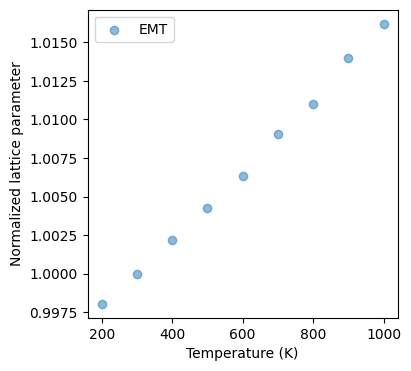

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ase.io import read,Trajectory

time_step = 10.0  # Time step size between each snapshots recorded in traj
paths = [f"fcc-Cu_3x3x3_NPT_EMT_{str(int(Temp)).zfill(4)}K.traj" for Temp in temperature_list]
path_list = sorted([ p for p in paths ])

# Temperature list extracted from the filename
temperature = [ float((p.split("_")[-1].replace("K","")).split('.traj')[0]) for p in path_list ]
print("temperature = ",temperature)

# Compute lattice parameter
lat_a = []
for path in path_list:
    print(f"path = {path}")
    traj = Trajectory(path)
    vol = [ atoms.get_volume() for atoms in traj ]
    lat_a.append(np.mean(vol[int(len(vol)/2):])**(1/3))

print("lat_a = ",lat_a)

# Normalize relative to the value at 300 K (which is at index 1 in the temperature_list)
norm_lat_a = np.array(lat_a)/lat_a[1]
print("norm_lat_a = ", norm_lat_a)
# Compute linear thermal expansion coefficient
# For linear thermal expansion coefficient α = (1/L)*(dL/dT)
# where L is the lattice parameter at reference temperature (300K)

# Using polyfit to get the slope of lattice parameter vs temperature
coef = np.polyfit(temperature, norm_lat_a, 1)
slope = coef[0]  # This is dL/dT normalized by L at 300K
alpha = slope  # Since we normalized by L at 300K, this is directly the coefficient

# Create a linear fit line for plotting
fit_line = np.polyval(coef, temperature)

# Print the thermal expansion coefficient
print(f"Linear thermal expansion coefficient: {alpha:.6e} K^-1")
# Plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Temperature (K)')  # x axis label
ax.set_ylabel('Normalized lattice parameter')  # y axis label
ax.scatter(temperature[:len(norm_lat_a)],norm_lat_a, alpha=0.5,label='EMT')
ax.legend(loc="upper left")


## Monte Carlo: Ising Model

In this practical, we will use Monte Carlo simulations to study the Ising model. The Ising model is a simple model of a ferromagnet, where spins on a lattice interact with their nearest neighbors. The Hamiltonian of the Ising model is given by

$$
H = -J \sum_{\langle i, j \rangle} s_i s_j - h \sum_i s_i,
$$

where $s_i = \pm 1$ are the spins on the lattice sites, $J$ is the coupling constant, $h$ is the external magnetic field, and the sum $\langle i, j \rangle$ is over nearest neighbors. We will consider the case of a 2D square lattice with periodic boundary conditions. In this simulation, $J=1$, $k_B=1$, $\beta = 1/T$ and $h=0$.

### Accelerate Python Code with Numba
The Monte Carlo simulation can be quite slow if implemented in pure Python. To speed up the simulation, we will use the Numba library, which can be used to compile Python code to machine code. To use Numba, you need to install it using `pip install numba`. You can then use the `@jit` decorator to compile a function. For example:

There are few things to keep in mind when using Numba:
- Numba does not support all Python features. For example, it does not support classes or list comprehensions.
- Numba does not support all Python libraries. For example, it does not support NumPy functions that create new arrays.
- Numba does not support all Python types. For example, it does not support complex numbers.

You should always test your Numba code to make sure it is working correctly.

In [ ]:
!pip install numba

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def initial_state(N):
    """
    Generate an N x N lattice with spins ±1.
    For better compatibility with Numba, using explicit array creation
    instead of relying on random.randint with subtraction.
    """
    config = np.empty((N, N), dtype=np.int64)
    for i in range(N):
        for j in range(N):
            # Randomly assign -1 or 1
            config[i, j] = 1 if np.random.random() < 0.5 else -1
    return config

def create_neighbor_list(N):
    """
    Create a neighbor list for each spin in the lattice.
    """
    neighbor_list = {}
    for i in range(N):
        for j in range(N):
            neighbors = [
                ((i+1) % N, j),
                ((i-1) % N, j),
                (i, (j+1) % N),
                (i, (j-1) % N)
            ]
            neighbor_list[(i, j)] = neighbors
    return neighbor_list

@njit
def mc_step(config, beta):
    """
    Perform one Monte Carlo sweep using the Metropolis algorithm.
    One sweep means N*N spin update attempts.
    
    Parameters:
      config: 2D numpy array of spins
      beta: 1/T (temperature inverse in natural units, with J=kB=1)
      neighbor_list: Dictionary of neighbors for each site (ignored in this implementation)
    Returns:
      Updated spin configuration.
    """
    N = config.shape[0]
    for _ in range(N*N):
        # Generate random coordinates for spin flip attempt
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        s = config[i, j]
        
        # Calculate energy difference directly from neighbors
        nb_sum = 0
        nb_sum += config[(i+1) % N, j]
        nb_sum += config[(i-1) % N, j]
        nb_sum += config[i, (j+1) % N]
        nb_sum += config[i, (j-1) % N]
        
        # Energy change if we flip this spin
        dE = 2 * s * nb_sum
        
        # Metropolis acceptance criterion
        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            config[i, j] = -s
    
    return config

@njit
def calc_energy(config, J=1):
    """
    Calculate the total energy of the configuration.
    
    Hamiltonian: H = -J Σ_{<ij>} s_i s_j with J=1.
    Each neighbor pair is counted twice so we divide by 2.
    """
    N = config.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            S = config[i, j]
            # Calculate contribution from neighbors directly
            nb_sum = config[(i+1) % N, j] + config[(i-1) % N, j] + config[i, (j+1) % N] + config[i, (j-1) % N]
            energy += -S * J * nb_sum
    return energy / 2.0

@njit
def calc_magnetization(config):
    """
    Calculate the magnetization of the configuration.
    
    Magnetization: M = Σ s_i
    """
    return np.sum(config)

@njit
def run_simulation(N, T, n_equil, n_steps):
    """
    Run a simulation at a specific temperature and return results
    """
    beta = 1.0 / T
    config = initial_state(N)
    
    # Equilibration
    for _ in range(n_equil):
        config = mc_step(config, beta)
    
    # Measurement
    E_total = 0.0
    M_total = 0.0
    configs = np.zeros((n_steps//100 + 1, N, N), dtype=np.int64)
    configs[0] = config.copy()
    
    save_idx = 1
    for step in range(n_steps):
        config = mc_step(config, beta)
        E_total += calc_energy(config)
        M_total += abs(calc_magnetization(config))
        
        if step % 100 == 0 and save_idx < len(configs):
            configs[save_idx] = config.copy()
            save_idx += 1
            
    E_avg = E_total / (n_steps * N * N)
    M_avg = M_total / (n_steps * N * N)
    
    return E_avg, M_avg, configs

# Function to create animation
def create_ising_animation(N=64, T=2.27, n_equil=1000, n_steps=10000):
    import plotly.graph_objects as go
    
    _, _, configs = run_simulation(N, T, n_equil, n_steps)
    
    # Create initial figure
    fig = go.Figure(
        data=go.Heatmap(
            z=configs[0],
            colorscale='RdBu',  # Red-Blue colorscale similar to coolwarm
            showscale=True,
            colorbar=dict(title='Spin'),
            zmin=-1, zmax=1
        ),
        layout=go.Layout(
            title=f'Ising Model at T = {T:.2f}, Frame 0',
            width=700, height=700,
            updatemenus=[{
                'type': 'buttons',
                'buttons': [{
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}]
                }, {
                    'label': 'Pause',
                    'method': 'animate',
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]
                }],
                'direction': 'left',
                'pad': {'r': 10, 't': 10},
                'showactive': False,
                'x': 0.1,
                'y': 0,
                'xanchor': 'right',
                'yanchor': 'top'
            }],
            sliders=[{
                'active': 0,
                'yanchor': 'top',
                'xanchor': 'left',
                'currentvalue': {
                    'visible': True,
                    'prefix': 'Frame: ',
                    'xanchor': 'right'
                },
                'transition': {'duration': 100},
                'pad': {'b': 10, 't': 50},
                'len': 0.9,
                'x': 0.1,
                'y': 0,
                'steps': [{
                    'method': 'animate',
                    'label': str(i),
                    'args': [[str(i)], {
                        'frame': {'duration': 100, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 100}
                    }]
                } for i in range(len(configs))]
            }]
        ),
        frames=[go.Frame(
                data=[go.Heatmap(z=configs[i])],
                name=str(i),
                layout=go.Layout(title_text=f'Ising Model at T = {T:.2f}, Frame {i}')
            ) for i in range(len(configs))
        ]
    )
    
    return fig

# Function to run full simulation with temperature sweep
def run_ising_simulation(N=64, temps=None, n_equil=1000, n_steps=10000):
    if temps is None:
        temps = np.linspace(1.5, 3.5, 21)
    
    magnetizations = []
    energies = []
    specific_heats = []
    
    for T in temps:
        print(f"Simulating T = {T:.2f} K")
        E_avg, M_avg, configs = run_simulation(N, T, n_equil, n_steps)
        energies.append(E_avg)
        magnetizations.append(M_avg)
        
        # Calculate energy fluctuations for specific heat
        # Need to run an additional loop to collect E^2 samples
        beta = 1.0 / T
        config = configs[-1].copy()  # Use the last config as starting point
        E_total = 0.0
        E_squared_total = 0.0
        
        for _ in range(n_steps):
            config = mc_step(config, beta)
            E = calc_energy(config)
            E_total += E
            E_squared_total += E**2
            
        E_avg = E_total / n_steps
        E_squared_avg = E_squared_total / n_steps
        # Specific heat: C = (β^2 / N^2) * (<E^2> - <E>^2)
        C = (beta**2) * (E_squared_avg - E_avg**2) / (N**2)
        specific_heats.append(C)
        
        print(f"T = {T:.2f} K, E = {E_avg:.3f} eV/spin, |M| = {M_avg:.3f}, C = {C:.3f}")
        
    # Create plot with 3 panels
    fig, (ax_mag, ax_eng, ax_heat) = plt.subplots(1, 3, figsize=(18, 5))
    
    ax_mag.plot(temps, magnetizations, 'o-', label='|M| per spin')
    ax_mag.set_xlabel('Temperature T')
    ax_mag.set_ylabel('Average Magnetization per Spin')
    ax_mag.set_title('Magnetization vs Temperature')
    ax_mag.set_xlim(temps[0], temps[-1])
    ax_mag.set_ylim(0, 1.0)
    ax_mag.legend()
    
    ax_eng.plot(temps, energies, 's-', color='red', label='E per spin')
    ax_eng.set_xlabel('Temperature T')
    ax_eng.set_ylabel('Average Energy per Spin')
    ax_eng.set_title('Energy vs Temperature')
    ax_eng.set_xlim(temps[0], temps[-1])
    ax_eng.set_ylim(-2.0, 0)
    ax_eng.legend()
    
    ax_heat.plot(temps, specific_heats, '^-', color='green', label='C per spin')
    ax_heat.set_xlabel('Temperature T')
    ax_heat.set_ylabel('Specific Heat per Spin')
    ax_heat.set_title('Specific Heat vs Temperature')
    ax_heat.set_xlim(temps[0], temps[-1])
    ax_heat.legend()
    
    fig.tight_layout()
    plt.show()
    
    return temps, magnetizations, energies, specific_heats
# Example usage
# Display animation for temperature near critical point
fig = create_ising_animation(N=500, T=2.1, n_equil=0, n_steps=10000)
fig.show()
# For full simulation with temperature sweep
run_ising_simulation(N=32, n_equil=1000, n_steps=10000)
